# **Studentsko istraživački rad 1**

---

Ovaj projekat koristi skup podataka koji sadrži 4242 slike cvetova podeljenih u 5 različitih klasa: kamilica, tulipan, ruža, suncokret i maslačak. Svaka klasa ima oko 800 slika različitih rezolucija i proporcija. 

Glavni cilj ovog projekta je izgradnja modela za klasifikaciju slika cvetova, koji može automatski prepoznati kojoj klasi (vrsti cveta) pripada svaka slika iz datog skupa. Klasifikacija slika je jedan od ključnih zadataka u oblasti računarskog vida i ima brojne primene u poljima kao što su biologija, poljoprivreda, automatizovana identifikacija biljnih vrsta i slično.

Za ovaj zadatak koristi se napredni model dubokog učenja pod nazivom EfficientNet, koji se pokazao kao veoma efikasan u različitim zadacima klasifikacije slika. EfficientNet je arhitektura konvolutivne neuronske mreže (CNN), dizajnirana da postigne visok nivo tačnosti uz relativno manju složenost i potrošnju resursa u poređenju sa drugim modelima.

# **1. Treniranje modela**

## **1.1. Uvoz biblioteka**

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.model_selection import KFold, train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision.models import EfficientNet_B0_Weights
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

## **1.2. Priprema podataka**

Učitavanje putanja slika, kreiranje dataframe-a, enkodiranje labela i podela podataka na trening i test set.

In [2]:
save_path = r'C:\Users\dual\Milica\sir 1\Models'
dataset_path = r'C:\Users\dual\Milica\sir 1\flowers'

In [3]:
paths = []
labels = []

# Prolazimo kroz direktorijume slika i za svaku sliku čuvamo putanju i labelu (ime cveta).
for flower_type in os.listdir(dataset_path):
    cur_path = os.path.join(dataset_path, flower_type)
    for img_name in os.listdir(cur_path):
        paths.append(os.path.join(cur_path, img_name))
        labels.append(flower_type)

# Kreiramo DataFrame sa putanjama i labelama.
data = pd.DataFrame({"path": paths, "label": labels})

# LabelEncoder se koristi za konvertovanje tekstualnih labela (imena cvetova) u numeričke vrednosti.
le = preprocessing.LabelEncoder()
data['label'] = le.fit_transform(data['label'])

## **1.3. Kreiranje DataLoader-a**

Kreiramo klasu Dataset koja omogućava PyTorch-u da lakše manipuliše i učitava podatke.

In [4]:
class ClassificationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.le = preprocessing.LabelEncoder()
        self.data.loc[:, 'label'] = self.le.fit_transform(self.data['label']).astype(int)
        self.classes_ = self.le.classes_

    def __getitem__(self, idx):
        img = Image.open(self.data.iloc[idx, 0]).convert('RGB')
        label = self.data.iloc[idx, 1]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label).long()

    def __len__(self):
        return len(self.data)

In [5]:
# Funkcija za pravljenje DataLoader-a
def make_loader(dataset, batch_size, validation_split=0.2):
    train_len = int(len(dataset) * (1 - validation_split))
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [6]:
# # Definišemo transformacije za slike (resize, konverzija u tenzor i normalizacija).
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Podela podataka na trening i test set (80% trening, 20% test)
x_train, x_test, y_train, y_test = train_test_split(data['path'], data['label'], test_size=0.2, stratify=data['label'])

In [8]:
# Kreiramo PyTorch Dataset i DataLoader za trening podatke
train_data = pd.DataFrame({"path": x_train, "label": y_train})
test_data = pd.DataFrame({"path": x_test, "label": y_test})

In [9]:
# 4. Kreiranje Dataset-a i DataLoader-a za autoencoder
train_dataset = ClassificationDataset(train_data, transform=transformer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## **1.4. Kreiranje i treniranje autoencoder-a**

Autoencoder model se koristi za detekciju anomalija u skupu podataka (npr. oštećene ili loše slike).

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Koristimo sigmoid za normalizovane slike
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## **1.5. Uklanjanje anomalija**

In [11]:
# Treniranje autoencoder-a
def train_autoencoder(model, dataloader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader)}")
    return model

# Primenite autoencoder na dataset i detektujte slike sa visokim gubitkom
def detect_anomalies(model, dataloader, threshold, original_indices):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    anomalies = []
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images).mean(dim=(1, 2, 3))

            anomaly_idx = np.where(loss.cpu().numpy() > threshold)[0]
            batch_indices = original_indices[i * dataloader.batch_size : (i + 1) * dataloader.batch_size]
            anomalies.extend(batch_indices[anomaly_idx])

    return anomalies

In [12]:
# Treniranje autoencoder-a i detekcija anomalija na celom skupu
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer_autoencoder = optim.Adam(autoencoder.parameters(), lr=0.001)
trained_autoencoder = train_autoencoder(autoencoder, train_loader, criterion, optimizer_autoencoder, epochs=10)

In [13]:
# Definišite prag za rekonstrukcijski gubitak
threshold = 0.2

# 1. Kreiraj niz indeksa za slike u train setu
original_indices = np.arange(len(train_dataset))

# 2. Primenite autoencoder na dataset i detektujte slike sa visokim gubitkom
anomalies = detect_anomalies(trained_autoencoder, train_loader, threshold, original_indices=original_indices)

print(f"Pronađeno {len(anomalies)} anomalija.")


In [14]:
# 3. Ukloni anomalije iz trening skupa
valid_anomalies = [idx for idx in anomalies if idx in train_data.index]
train_data_cleaned = train_data.drop(index=valid_anomalies).reset_index(drop=True)

# 4. Kreiraj očišćeni dataset i DataLoader nakon uklanjanja anomalija
train_dataset_cleaned = ClassificationDataset(train_data_cleaned, transform=transformer)

# **2. Kreiranje i treniranje EfficientNet modela**

## **2.1.. Kreiranje EfficientNet modela**

Definisanje EfficientNet-B0 modela sa unapred treniranim težinama i prilagođenom klasifikacionom glavom za klasifikaciju slika u 5 klasa.

In [15]:
def create_efficientnet_model(num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    
    # Prilagođavamo klasifikacionu glavu za 5 klasa (klase cvetova)
    classifier = nn.Sequential(
        nn.Linear(in_features=model.classifier[1].in_features, out_features=256),
        nn.ReLU(),  # Aktivaciona funkcija ReLU
        nn.Dropout(0.4),  # Dropout sloj za regularizaciju
        nn.Linear(256, num_classes) # Konačni sloj za 5 klasa
    )
    
    model.classifier = classifier
    return model.to(device)


## **2.2. Treniranje modela koristeći K-fold cross-validation**

K-fold cross-validation metod za treniranje modela na više podskupova i poboljšanje procene performansi.

In [17]:
# Čuvamo model nakon svakog folda
def save_model(model, model_filename):
    model_save_path = os.path.join(save_path, model_filename)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model sačuvan na: {model_save_path}")

In [18]:
# Funkcija za treniranje jedne epohe
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Resetovanje gradijenata
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Izračunavanje gubitka
        loss.backward()  # Backward pass
        optimizer.step()  # Ažuriranje težina

        train_loss += loss.item()  # Ukupni gubitak
        _, predicted = torch.max(output, 1)  # Predikcija klase
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return train_loss / len(train_loader), correct / total  # Vraćamo prosečan gubitak i tačnost


In [19]:
# Funkcija za validaciju modela
def validate(model, val_loader, criterion, device):
    model.eval() # Model je u evaluacionom modu
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) # Forward pass
            loss = criterion(output, target) # Izračunavanje gubitka

            val_loss += loss.item() # Ukupni gubitak
            _, predicted = torch.max(output, 1) # Predikcija klase
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return val_loss / len(val_loader), correct / total, all_preds, all_targets

In [20]:
# EarlyStopping klasa za zaustavljanje treniranja ako validacioni gubitak prestane da se smanjuje.
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience  # Koliko epoha da sačekamo pre zaustavljanja
        self.min_delta = min_delta  # Minimalno poboljšanje koje se smatra značajnim
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss  # Prva epoha postavlja najbolji gubitak
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1  # Ako nema značajnog poboljšanja, povećavamo brojač
            if self.counter >= self.patience:  # Ako smo premašili broj epoha za čekanje, zaustavljamo treniranje
                self.early_stop = True
        else:
            self.best_loss = val_loss  # Ako je gubitak manji, resetujemo brojač
            self.counter = 0

In [21]:
# K-fold cross-validation metoda za treniranje modela na više podskupova podataka.
def k_fold_train(data, n_splits=5, batch_size=32, epochs=10, num_classes=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    models = []

    # Kreiramo K-fold instancu
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Prolazimo kroz svaki fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
        print(f"Fold {fold+1}/{n_splits}")

        # Podela podataka na trening i validacioni skup za trenutni fold
        train_data_fold = data.iloc[train_idx]
        val_data = data.iloc[val_idx]

        # Kreiramo DataLoader za trening i validacioni skup
        train_dataset_fold = ClassificationDataset(train_data_fold, transform=transformer)
        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_dataset = ClassificationDataset(val_data, transform=transformer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Kreiramo EfficientNet model
        model = create_efficientnet_model(num_classes)
        optimizer_model = optim.Adam(model.classifier.parameters(), lr=0.001)

        # Treniranje modela za trenutni fold
        for epoch in range(epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader_fold, optimizer_model, criterion, device)
            val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, device)
            print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Čuvamo trenirani model za trenutni fold
        model_filename = f'efficientnet_model_fold_{fold}.pth'
        save_model(model, model_filename)
        models.append(model)

    return models  # Vraćamo listu treniranih modela za svaki fold

In [22]:
# Funkcija za stratifikovano K-fold treniranje (osigurava da svaki fold sadrži proporcionalne klase).
def stratified_k_fold_train(data, labels, n_splits=5, batch_size=32, epochs=30, num_classes=5, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    trained_models = []

    # StratifiedKFold osigurava proporcionalnost klasa unutar svakog folda
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Prolazimo kroz svaki fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"Fold {fold+1}/{n_splits}")

        # Podela podataka na trening i validacioni skup za trenutni fold
        train_data_fold = data.iloc[train_idx]
        val_data = data.iloc[val_idx]

        # Kreiramo DataLoader za trening i validacioni skup
        train_dataset_fold = ClassificationDataset(train_data_fold, transform=transformer)
        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_dataset = ClassificationDataset(val_data, transform=transformer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Kreiramo EfficientNet model
        model = create_efficientnet_model(num_classes)
        optimizer_model = optim.Adam(model.classifier.parameters(), lr=0.001)

        # Inicijalizujemo EarlyStopping
        early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

        # Treniranje modela za trenutni fold
        for epoch in range(epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader_fold, optimizer_model, criterion, device)
            val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, device)

            print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Early stopping proverava da li treba prekinuti treniranje
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping activated!")
                break

        model_filename = f'efficientnet_model_stratified_fold_{fold}.pth'
        save_model(model, model_filename)  
        trained_models.append(model)
    return trained_models

In [23]:
# K-fold treniranje sa očišćenim podacima
models_1 = k_fold_train(train_data_cleaned, n_splits=5, batch_size=32, epochs=10, num_classes=5)

In [24]:
# K-fold treniranje sa originalnim (nečišćenim) podacima
models_2 = stratified_k_fold_train(train_data, train_data['label'], n_splits=5, batch_size=32, epochs=30, num_classes=5, patience=5)

Fold 1/5
Epoch 1: Train loss: 0.6556, Train Acc: 0.7828, Val Loss: 0.3617, Val Acc: 0.8770
Epoch 2: Train loss: 0.3575, Train Acc: 0.8773, Val Loss: 0.3260, Val Acc: 0.8828
Epoch 3: Train loss: 0.3099, Train Acc: 0.8954, Val Loss: 0.3156, Val Acc: 0.8915
Epoch 4: Train loss: 0.2832, Train Acc: 0.8986, Val Loss: 0.3218, Val Acc: 0.8842
Epoch 5: Train loss: 0.2406, Train Acc: 0.9207, Val Loss: 0.3084, Val Acc: 0.8915
Epoch 6: Train loss: 0.2307, Train Acc: 0.9160, Val Loss: 0.3288, Val Acc: 0.8857
Epoch 7: Train loss: 0.1839, Train Acc: 0.9341, Val Loss: 0.3010, Val Acc: 0.8944
Epoch 8: Train loss: 0.1693, Train Acc: 0.9410, Val Loss: 0.3191, Val Acc: 0.8828
Epoch 9: Train loss: 0.1473, Train Acc: 0.9529, Val Loss: 0.2959, Val Acc: 0.8944
Epoch 10: Train loss: 0.1312, Train Acc: 0.9566, Val Loss: 0.3116, Val Acc: 0.8929
Epoch 11: Train loss: 0.1348, Train Acc: 0.9562, Val Loss: 0.3120, Val Acc: 0.8958
Epoch 12: Train loss: 0.1054, Train Acc: 0.9638, Val Loss: 0.3218, Val Acc: 0.8915
Epoc

# **3. Evaluacija performansi**

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [26]:
# Funkcija za prosečnu verovatnoću (average probabilities)
# Ova funkcija kombinuje rezultate svih modela (ansambl) i računa prosečne verovatnoće za svaku klasu.
def average_probabilities(models, test_loader, device):
    avg_probs = []

    with torch.no_grad():  # Isključujemo računanje gradijenata
        for data, _ in test_loader:
            data = data.to(device)
            batch_probs = []

            for model in models:
                output = model(data)
                probs = torch.softmax(output, dim=1)  # Softmax pretvara logit u verovatnoće
                batch_probs.append(probs.cpu().numpy())  # Skupljamo verovatnoće za svaku sliku

            avg_batch_probs = np.mean(batch_probs, axis=0)  # Računamo prosečne verovatnoće
            avg_probs.append(avg_batch_probs)

    return np.vstack(avg_probs)  # Vraćamo prosečne verovatnoće za sve slike

In [27]:
# Funkcija za većinsko glasanje (majority voting)
# Ova funkcija koristi većinsko glasanje (ansambl metoda) za donošenje konačne odluke o klasi.
def majority_voting(models, test_loader, device):
    all_preds = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            batch_preds = []

            for model in models:
                output = model(data)
                preds = torch.argmax(output, dim=1)  # Biramo klasu sa najvećom verovatnoćom
                batch_preds.append(preds.cpu().numpy())

            batch_preds = np.array(batch_preds)
            majority_preds = [np.bincount(col).argmax() for col in batch_preds.T]  # Većinsko glasanje
            all_preds.append(majority_preds)

    return np.concatenate(all_preds)  # Vraćamo konačne predikcije za sve slike

In [28]:
# Testiranje modela
# Funkcija testira modele koristeći prosečne verovatnoće ili većinsko glasanje.
def test_model(models, test_loader, device, method="average"):
    if method == "average":
        avg_probs = average_probabilities(models, test_loader, device)
        final_predictions = np.argmax(avg_probs, axis=1)  # Predikcija na osnovu najveće prosečne verovatnoće
    else:
        final_predictions = majority_voting(models, test_loader, device)  # Predikcija putem većinskog glasanja
    return final_predictions

In [29]:
# Funkcija za crtanje gubitka po epochama
def plot_loss(train_losses, val_losses, epochs, title="Training and Validation Loss per Epoch"):
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [30]:
# Funkcija za crtanje tačnosti po epochama
def plot_accuracy(train_accs, val_accs, epochs, title="Training and Validation Accuracy per Epoch"):
    plt.plot(range(1, epochs+1), train_accs, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

In [31]:
# Funkcija za crtanje matrice konfuzije
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

In [32]:
# Funkcija za crtanje ROC krive za sve klase
def plot_roc_curves(y_true, y_probs, num_classes, title="ROC Curves for All Classes"):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    plt.figure(figsize=(10, 7))
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

In [33]:
# Funkcija za crtanje distribucije grešaka
def plot_error_distribution(y_true, y_pred, title="Distribution of Prediction Errors"):
    errors = y_true - y_pred
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

In [34]:
# Funkcija za crtanje distribucije predikcija po klasama
def plot_prediction_distribution(y_pred, class_names, title="Prediction Distribution Across Classes"):
    plt.hist(y_pred, bins=len(class_names), rwidth=0.8, align='mid')
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

In [43]:
# Funkcija za učitavanje modela
def load_model(fold, model_class, num_classes, model_dir=save_path):
    model_filename = f'efficientnet_model_stratified_fold_{fold}.pth'
    model_path = os.path.join(model_dir, model_filename)
    model = model_class(num_classes)
    model.load_state_dict(torch.load(model_path))  # Učitavamo parametre modela iz datoteke
    model.eval()  # Prebacujemo model u eval mod (bez računanja gradijenata)
    return model

In [44]:
# Kreiraj test DataLoader
test_dataset = ClassificationDataset(test_data, transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Učitavamo trenirane modele za svaki fold
models_2 = [load_model(fold, create_efficientnet_model, 5) for fold in range(5)]

C:\Users\dual\AppData\Local\Temp\ipykernel_16308\4023442825.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Učitavamo pa

In [46]:
# Testiranje modela sa prosečnim verovatnoćama (average probabilities)
test_preds_avg = test_model(models_2, test_loader, device, method="average")
print("Izveštaj za prosečne verovatnoće:")
print(classification_report(y_test, test_preds_avg, target_names=le.classes_))

# Testiranje modela sa većinskim glasanjem (majority voting)
test_preds_majority = test_model(models_2, test_loader, device, method="majority")
print("Izveštaj za većinsko glasanje:")
print(classification_report(y_test, test_preds_majority, target_names=le.classes_))


Izveštaj za prosečne verovatnoće:
              precision    recall  f1-score   support

       daisy       0.96      0.88      0.92       153
   dandelion       0.92      0.95      0.93       210
        rose       0.86      0.90      0.88       157
   sunflower       0.96      0.90      0.93       147
       tulip       0.87      0.90      0.89       197

    accuracy                           0.91       864
   macro avg       0.91      0.91      0.91       864
weighted avg       0.91      0.91      0.91       864

Izveštaj za većinsko glasanje:
              precision    recall  f1-score   support

       daisy       0.95      0.90      0.92       153
   dandelion       0.93      0.95      0.94       210
        rose       0.85      0.91      0.88       157
   sunflower       0.96      0.90      0.93       147
       tulip       0.89      0.89      0.89       197

    accuracy                           0.91       864
   macro avg       0.91      0.91      0.91       864
weighted avg

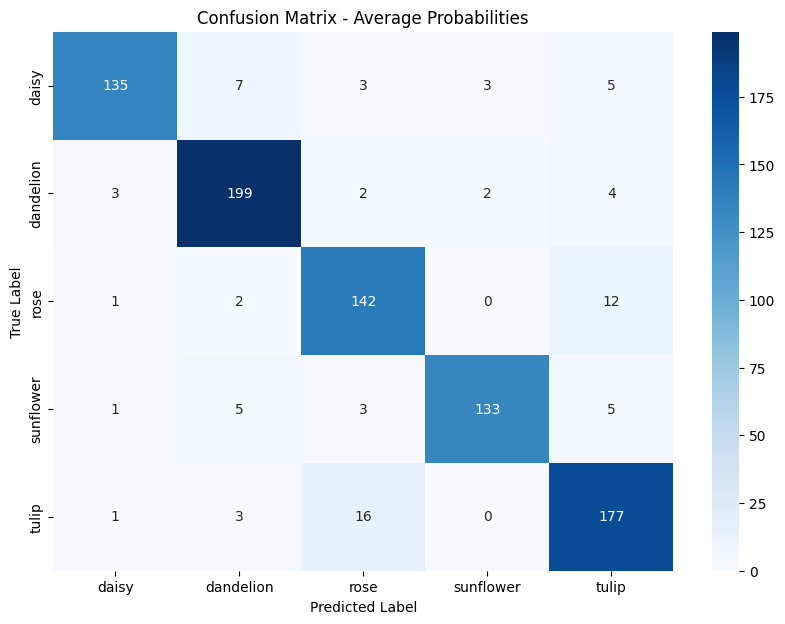

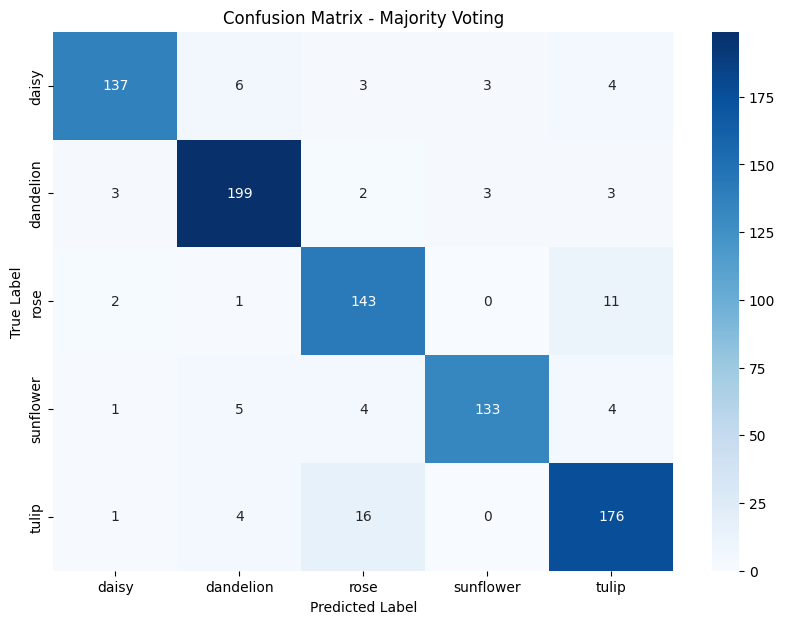

In [47]:
# Crtanje matrice konfuzije za obe metode
plot_confusion_matrix(y_test, test_preds_avg, le.classes_, title="Confusion Matrix - Average Probabilities")
plot_confusion_matrix(y_test, test_preds_majority, le.classes_, title="Confusion Matrix - Majority Voting")

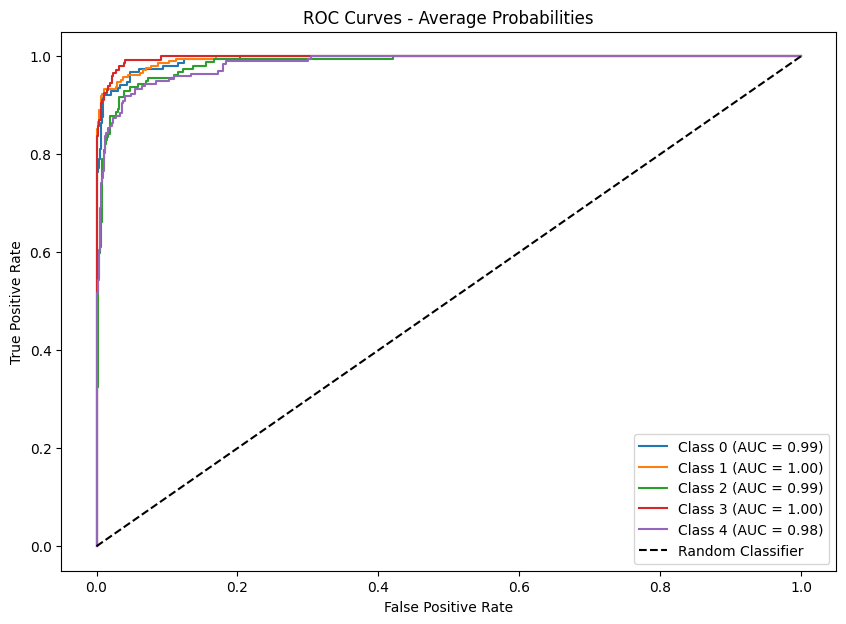

In [48]:
# Crtanje ROC krivih za prosečne verovatnoće
avg_probs = average_probabilities(models_2, test_loader, device)
plot_roc_curves(y_test, avg_probs, num_classes=5, title="ROC Curves - Average Probabilities")

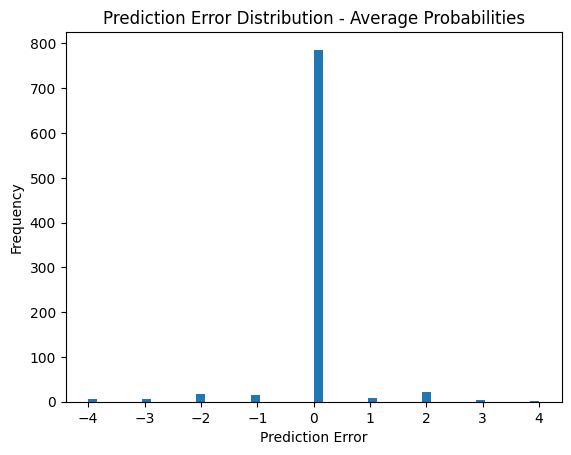

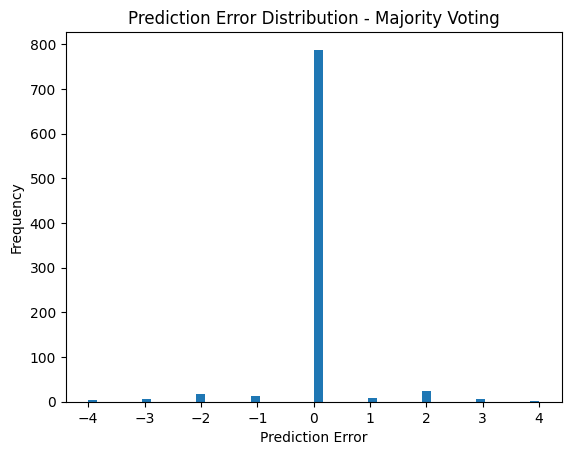

In [49]:
# Crtanje distribucije grešaka za obe metode
plot_error_distribution(y_test, test_preds_avg, title="Prediction Error Distribution - Average Probabilities")
plot_error_distribution(y_test, test_preds_majority, title="Prediction Error Distribution - Majority Voting")

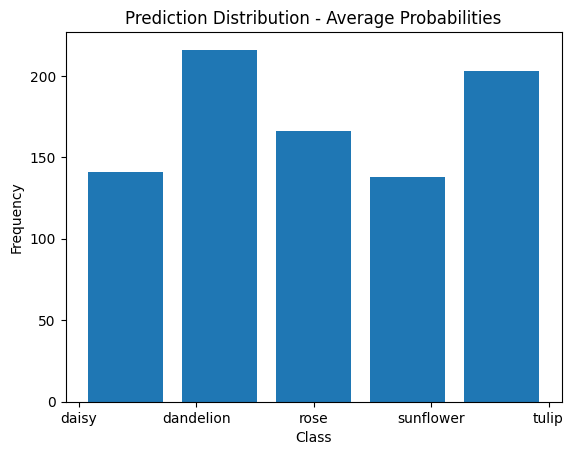

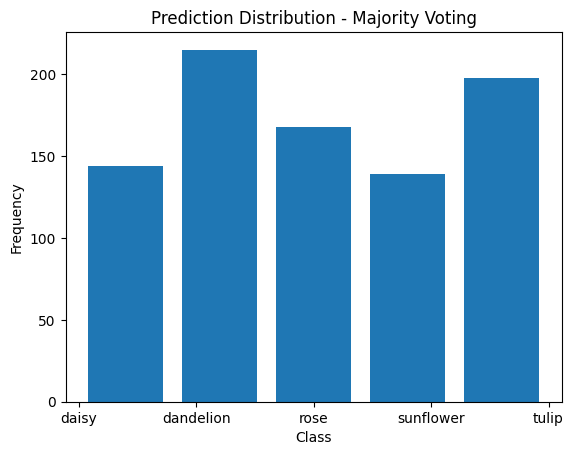

In [50]:
# Crtanje distribucije predikcija po klasama za obe metode
plot_prediction_distribution(test_preds_avg, le.classes_, title="Prediction Distribution - Average Probabilities")
plot_prediction_distribution(test_preds_majority, le.classes_, title="Prediction Distribution - Majority Voting")